# Los Angeles Homelessness By Land Use

An exploration of the Los Angeles homelessness counts allocated to land use categories.

The Los Angeles Homeless Services Authority is responsible for conducting the annual Point-In-Time-Count of homeless people in Los Angeles, and publishes the data to their website. This dataset is packaged for easier analysis at the [San Diego Regional Data Library's Data Repository. ](https://data.sandiegodata.org/dataset/lahsa-org-homeless_count-2018-los_angeles). This analysis links that data package to LA City tax assessor's parcels to study estimates of homless populations organized by land use categories. 



In [91]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack 
!{sys.executable} -mpip -q install contextily rtree descartes

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
sns.set(color_codes=True)


In [2]:
import metapack as mp

#pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-la_parcels-2.zip')
pkg = mp.open_package('index:sandiegodata.org-la_parcels-2')
plan_codes = pkg.resource('la-planning-code').dataframe()
tractparcels = pkg.resource('tract_to_parcels').geoframe()

pitc_pkg = mp.open_package('http://library.metatab.org/lahsa.org-homeless_count-2018-los_angeles-1.zip')
pitc_tracts = pitc_pkg.resource('tracts').dataframe().rename(columns={'tract':'geoid'})

tracts = rg.geoframe('census://2016/1/CA/tract').rename(columns={'tract':'geoid'})

In [76]:
# Add up acres per parcel per tract to get areas of the tract. This will 
# be less than whole area of the tract, but should be proportional to the actual area. 
tp = tractparcels.groupby(['geoid','code']).sum().acres.to_frame().reset_index()

# Find the indices of the land use in each tract that has the largest area
indices = tp.groupby('geoid').acres.idxmax()

# Then, reindex to get those rows. 
major_use = tp.loc[indices].reset_index()

In [6]:
lu = tracts[['geoid', 'geometry']].merge(major_use, on='geoid')
tpu =  tracts[['geoid', 'geometry']].merge(tp, on='geoid')

# Link tracts to communities
tract_communities = pitc_tracts[['geoid','community_name']]


In [232]:
# Calculate PITC tract counts expressed as density, people per acre
tot_cols = ['totvanpeople','totcamperpeople','tottentpeople','totmakeshiftpeople','totunsheltpeople']
den_cols = [ c+'_den' for c in tot_cols ]

t = pitc_tracts.merge(tracts,on='geoid') # Link to Census tract information

t=t[['geoid', 'aland']+tot_cols]

t['tract_acres'] = t.aland/4046.86 #  Convert to acres: 4047 sq m per acre

pitc_tracts_count = t.copy()

t.loc[:,tot_cols] = t.loc[:,tot_cols].div(t.tract_acres, axis=0) # Div each count in subset by acres to get density 

pitc_tracts_den = t
pitc_tracts_den.head()

,geoid,aland,totvanpeople,totcamperpeople,tottentpeople,totmakeshiftpeople,totunsheltpeople,tract_acres
0,14000US06037101110,1142402,0.017301,0.025945,0.0,0.005937,0.056268,282.293432
1,14000US06037101122,2644044,0.000000,0.000000,0.0,0.000000,0.005538,653.356924
2,14000US06037101210,650690,0.060750,0.022775,0.0,0.000000,0.138598,160.788859
3,14000US06037101220,698886,0.000000,0.031807,0.0,0.009705,0.083417,172.698339
4,14000US06037101300,2581214,0.000000,0.011483,0.0,0.000000,0.011483,637.831306


In [123]:
pitc_tracts_count.head()

,geoid,aland,totvanpeople,totcamperpeople,tottentpeople,totmakeshiftpeople,totunsheltpeople,tract_acres
0,14000US06037101110,1142402,4.884,7.324,0.0,1.676,15.884,282.293432
1,14000US06037101122,2644044,0.000,0.000,0.0,0.000,3.618,653.356924
2,14000US06037101210,650690,9.768,3.662,0.0,0.000,22.285,160.788859
3,14000US06037101220,698886,0.000,5.493,0.0,1.676,14.406,172.698339
4,14000US06037101300,2581214,0.000,7.324,0.0,0.000,7.324,637.831306


In [409]:
# Add a basemap, as per the Geopandas documentation. 
def add_basemap(ax, zoom=10, url=ctx.sources.ST_TONER_BACKGROUND):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
def plot_with_basemap(df, column=None, title='', cmap='tab10', zoom=10):
    
    
    # The web tiles are in epsg=3857, so we have to transform our map
    ax = df.to_crs(epsg=3857).plot(column=column, figsize=(15, 15), alpha=0.8,
                                   edgecolor='k', cmap=cmap, legend=True)
    add_basemap(ax, zoom=zoom )
    
    ax.set_title(title, fontsize=18);

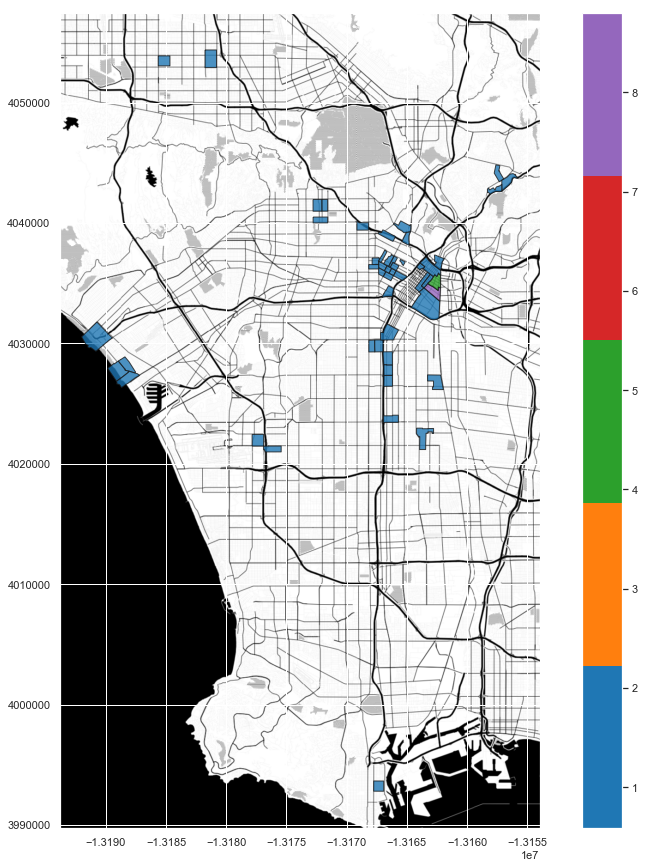

In [410]:
import scipy.stats as stats
t = tracts[['geoid', 'geometry']].set_index('geoid')\
    .join(pitc_tracts_den[['geoid','totunsheltpeople']].set_index('geoid'), how='right')

t = t.sort_values('totunsheltpeople', ascending=False).head(50)

cmap = plt.cm.get_cmap('tab10')
cmap.N = 5


plot_with_basemap(t, 'totunsheltpeople' , zoom=12, cmap=cmap)


In [406]:
plt.cm.get_cmap('tab10')

,geoid,tract_acres,totvanpeople,totcamperpeople,tottentpeople,totmakeshiftpeople,totunsheltpeople
654,14000US06037206300,152.379129,0.010684,0.012016,3.605546,2.090181,8.801547
227,14000US06037206200,143.009642,0.000000,0.025607,1.622058,0.867424,4.074425
2086,14000US06037207102,102.559762,0.047621,0.017853,0.595214,0.686478,1.762709
657,14000US06037209403,34.149686,0.047672,0.107234,0.178772,0.490868,1.428300
162,14000US06037209510,45.092244,0.288830,0.081211,0.372281,0.260222,1.384806


In [253]:
# Per-tract counts merged with census tract info
t = tracts[['geoid','geometry']].merge( pitc_tracts_count, on='geoid')
t = t[['geoid', 'tract_acres'] + tot_cols ] 

# Area of all parcels per tract
tp = tractparcels.groupby(['geoid','code']).sum().acres.to_frame().reset_index()

t = t.merge(tp, on='geoid') # Merge land use groups per tract to tracts

x = t

#Compute the area of the tract from the sum of the land-use categories per tract
tot_acres_per_geoid = t.groupby('geoid').acres.sum().to_frame().rename(columns={'acres':'tract_acres_parcel'})

# Add to each tract/landuse row the total area for the tract
t = t.merge(tot_acres_per_geoid, on='geoid')

# Divide the two to get the portion of each tract in each land use category
t['tract_portion'] = t.acres / t.tract_acres_parcel

assert tp_areas.groupby('geoid').sum().tract_portion.mean() == 1

for c in tot_cols:
    t[c] = t[c] * t.tract_portion

# Within tracts, 'acres' must sum to 'tract_acres_parcel'
_ = tract_code_counts.groupby('geoid').agg({'acres': 'sum', 'tract_acres': 'first', 'tract_acres_parcel': 'first'})
assert all((_.acres - _.tract_acres_parcel).round(4) == 0)
 
# Add in the land use code names


tract_code_counts = t.copy()

tract_code_den = t.copy()

# Compute densities
for c in tot_cols:
    tract_code_den[c] = tract_code_den[c] * t.tract_portion
    tract_code_den.rename(columns={c:c+'_den'}, inplace=True)


tract_code_den = tract_code_den.drop(['acres', 'tract_acres_parcel', 'tract_acres','tract_portion'], axis=1) 

tract_code = tract_code_counts.merge(tract_code_den, on=['geoid','code'])
    
# acres: area of the landuse code areas within the tract
# tract_acres_parcel: sum of the areas of all of the parcels in the tract
# tract_acres: Area calculated for the hole tract, which is more than tract_acres_parcel
tract_code = tract_code[['geoid', 'code','acres', 'tract_acres_parcel', 'tract_acres', 'tract_portion']
                         + tot_cols + den_cols ]

tract_code = tract_code.merge(plan_codes, on='code').rename(columns={'scag_gp_co': 'code_name'})
  

tract_code.head().T 

,0,1,2,3,4
geoid,14000US06037204920,14000US06037205110,14000US06037205120,14000US06037206010,14000US06037206050
code,1120,1120,1120,1120,1120
acres,46.8103,49.2293,47.5313,58.1425,31.1049
tract_acres_parcel,164.063,57.6291,283.251,252.893,293.473
tract_acres,224.859,70.9093,362.288,350.429,406.099
tract_portion,0.285318,0.854244,0.167806,0.229909,0.105989
totvanpeople,0.928997,1.39071,0.819566,0,0.51765
totcamperpeople,10.4481,0,1.22901,3.36771,0.970329
tottentpeople,0,0,0,0.350842,0.323478
totmakeshiftpeople,0,0,2.25045,0.770886,0.177637


In [245]:
agg_map.update({
    'code_name' : 'first',
    'acres' : 'sum'
 
})

agg_map.update({c:'sum' for c in tot_cols})

t = tract_code.groupby('code').agg(agg_map).copy()

for c in tot_cols:
    t[c+'_den'] = t[c] / t['acres']

by_codes = t
    
by_codes.head().T
    

code,0,1100,1110,1120,1130
totvanpeople,4.53746,2.65542,983.007,1019.62,0.292685
totcamperpeople,11.555,0.00265285,2415.85,1483.76,2.23948
tottentpeople,6.77855,0.696143,429.694,875.229,0.0116263
totmakeshiftpeople,12.4484,1.54515,1067.38,1333.71,1.51171
totunsheltpeople,75.87,12.8624,8137.72,8245.03,8.39207
acres,2054.63,2989.99,456639,66390.8,664.422
code_name,NaN,1100 Residential,1110 Single Family Residential,1120 Multi-Family Residential,1130 Mobile Homes and Trailer Parks
totvanpeople_den,0.00220841,0.000888102,0.0021527,0.0153579,0.00044051
totcamperpeople_den,0.00562387,8.87244e-07,0.00529049,0.0223489,0.00337057
tottentpeople_den,0.00329916,0.000232824,0.000940992,0.013183,1.74984e-05


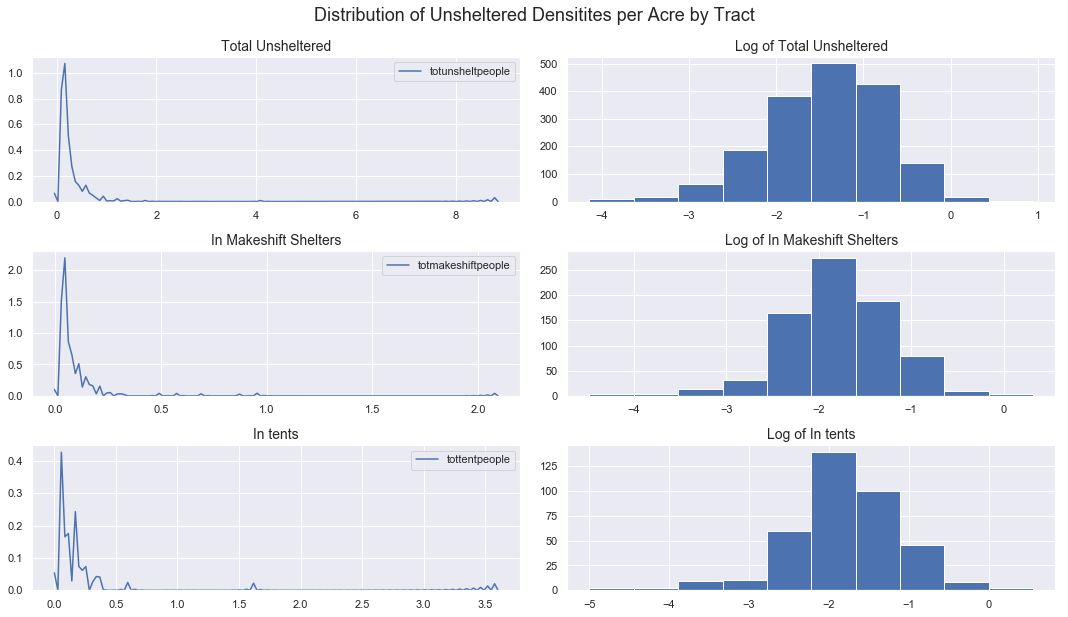

In [305]:
col = 'totunsheltpeople'
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(15,9))
axes = axes.ravel()

def density_dist(df, col, axes, pos, title):
    # Distribution of densities below 75% percentile
    #q_75 = df[col].describe().at['75%']
    #df[df[col] < q_75][col].hist(ax=axes[pos])
    #df[col].hist(ax=axes[pos])
    
    sns.kdeplot(df[col], ax=axes[pos])
    axes[pos].set_title(title, fontsize=14);

    np.log10(df[df[col]> 0][col]).hist(ax=axes[pos+1])
    axes[pos+1].set_title('Log of '+title, fontsize=14);

density_dist(pitc_tracts_den, 'totunsheltpeople', axes, 0, 'Total Unsheltered')
density_dist(pitc_tracts_den, 'totmakeshiftpeople', axes, 2, 'In Makeshift Shelters')
density_dist(pitc_tracts_den, 'tottentpeople', axes, 4, 'In tents')

fig.suptitle('Distribution of Unsheltered Densitites per Acre by Tract', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    
    

In [ ]:
def add_lu_codes(df):
    """"The LU codes don't survive groupby"""
    return df.merge(plan_codes.rename(columns={'scag_gp_co':'code_name'}), on='code')

def barchart(df, title,  x_col, x_lab, y_col, y_lab, n=5):

    df = df.sort_values(y_col, ascending=False).head(n)
    
    plt.figure(figsize=(8,6))

    ax = sns.barplot(x=x_col, y=y_col, data=df)

    plt.xticks(rotation=30);

    ax.set_title(title, fontsize=16);
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab);

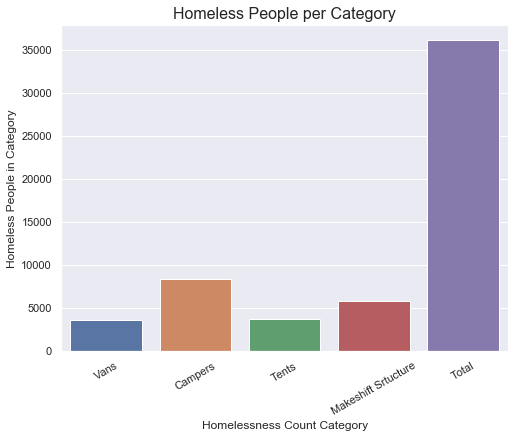

In [360]:
t = by_codes[tot_cols].stack().to_frame().reset_index()
t.columns = ['code','measure','value']

plt.figure(figsize=(8,6))
ax = sns.barplot(x="measure", y="value", data=t, ci=None, estimator=np.sum)
plt.xticks(rotation=30);

ax.set_title("Homeless People per Category", fontsize=16);
ax.set_xlabel('Homelessness Count Category')
ax.set_ylabel('Homeless People in Category');
plt.xticks(np.arange(5), ('Vans', 'Campers', 'Tents', 'Makeshift Srtucture', 'Total'));
    

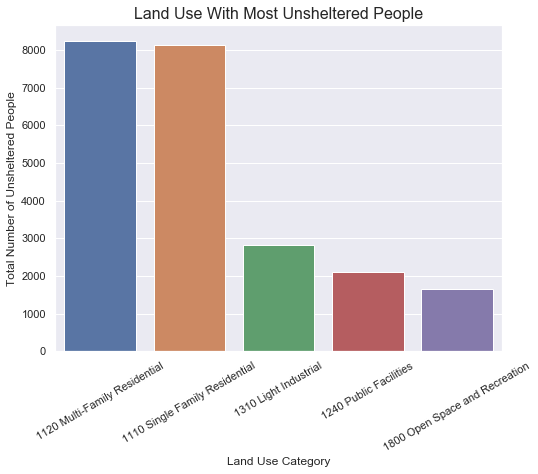

In [338]:
barchart( by_codes, 
         'Land Use With Most Unsheltered People',
         "code_name",'Land Use Category',
         "totunsheltpeople", "Total Number of Unsheltered People")

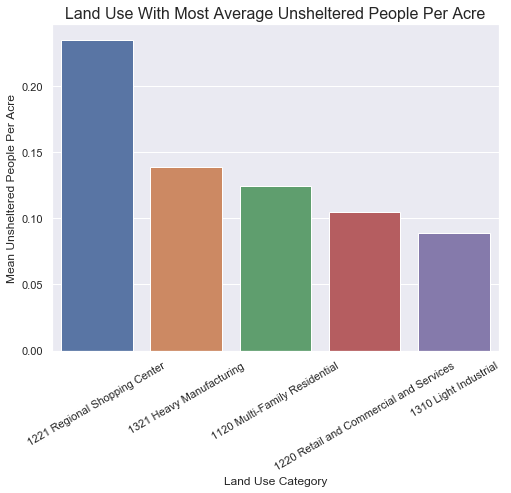

In [337]:
barchart(by_codes,
         'Land Use With Most Average Unsheltered People Per Acre',
         "code_name",'Land Use Category',
         "totunsheltpeople_den", "Mean Unsheltered People Per Acre")

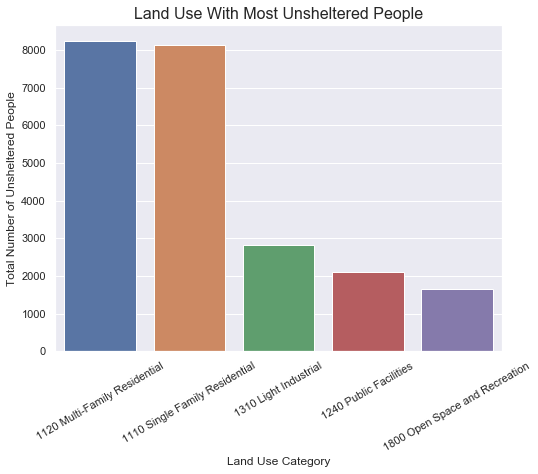

In [382]:
barchart( by_codes, 
         'Land Use With Most Unsheltered People',
         "code_name",'Land Use Category',
         "totunsheltpeople", "Total Number of Unsheltered People")

In [368]:
pitc_tracts.groupby('community_name').sum().totunsheltpeople.sort_values(ascending=False).head(25)

community_name
Skid Row                          2091.779
Downtown Los Angeles              1462.068
Unincorporated Antelope Valley    1280.261
North Hollywood                   1010.712
Hollywood                          989.972
Lancaster                          902.806
South Park                         816.643
Florence-Graham                    729.034
Venice                             727.791
Vermont Square                     724.346
Santa Monica                       718.448
Westlake                           706.662
Pomona                             585.340
El Monte                           514.229
Sun Valley                         505.047
Echo Park                          488.001
South Central                      476.216
Wilmington                         472.690
Carson                             461.109
Boyle Heights                      451.840
Willowbrook                        402.961
Sylmar                             399.181
Chinatown                          387.

In [378]:
t = tract_code[['geoid','code','code_name','totunsheltpeople']].merge(tract_communities, on='geoid')
t['totunsheltpeople'] = t.totunsheltpeople.round()
t = t.groupby(['code_name','community_name']).sum().totunsheltpeople.to_frame().reset_index()
t.sort_values('totunsheltpeople', ascending=False).head(10)

,code_name,community_name,totunsheltpeople
1319,1310 Light Industrial,Skid Row,1112.0
483,1150 Rural Residential,Unincorporated Antelope Valley,1026.0
1283,1310 Light Industrial,Downtown Los Angeles,625.0
343,1120 Multi-Family Residential,South Park,500.0
272,1120 Multi-Family Residential,Hollywood,476.0
114,1110 Single Family Residential,North Hollywood,461.0
93,1110 Single Family Residential,Lancaster,451.0
363,1120 Multi-Family Residential,Venice,369.0
364,1120 Multi-Family Residential,Vermont Square,364.0
421,1140 Mixed Residential,Florence-Graham,358.0


In [381]:
t[t.community_name == 'Skid Row']

,code_name,community_name,totunsheltpeople
339,1120 Multi-Family Residential,Skid Row,312.0
840,1220 Retail and Commercial and Services,Skid Row,188.0
910,1221 Regional Shopping Center,Skid Row,348.0
1091,1240 Public Facilities,Skid Row,90.0
1319,1310 Light Industrial,Skid Row,1112.0
1863,1800 Open Space and Recreation,Skid Row,43.0
